In [9]:
# import libraries

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from spotlib import search_song, get_audio_features, add_audio_features
import numpy as np
import sys
sys.path.insert(1, 'config.py')
from config import *
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
from time import sleep
from bs4 import BeautifulSoup
import requests



danceability    0
valence         0
dtype: int64
danceability    0
valence         0
dtype: int64


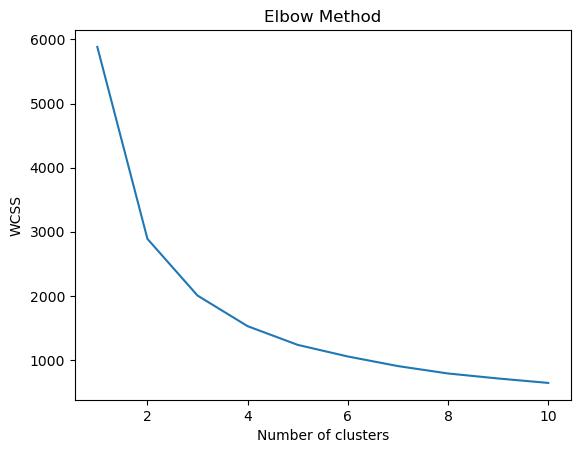

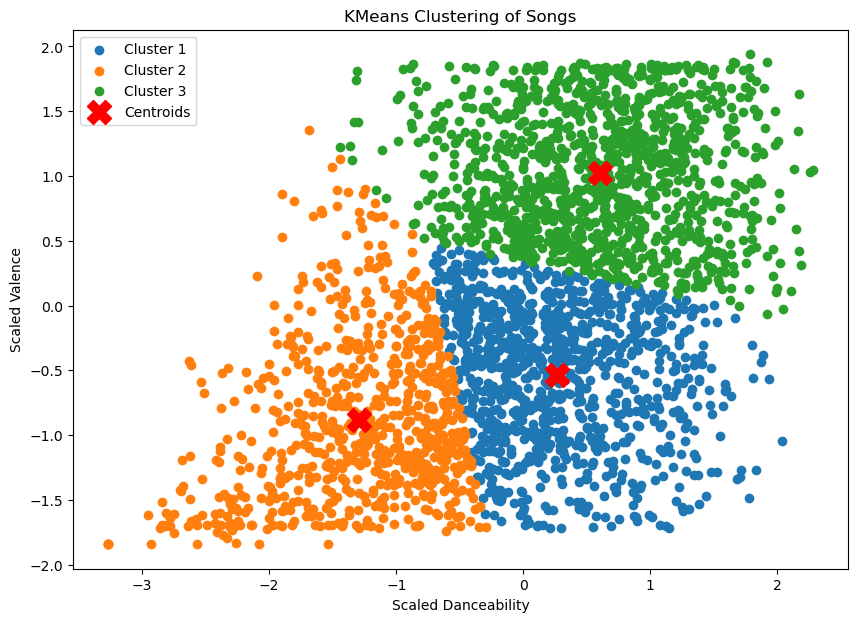

                    Song                                Artist  \
0     Paint The Town Red                              Doja Cat   
1                 Snooze                                   SZA   
2               Fast Car                            Luke Combs   
3           Cruel Summer                          Taylor Swift   
4  I Remember Everything  Zach Bryan Featuring Kacey Musgraves   

               Spotify_ID  danceability  energy  key  loudness  mode  \
0  2IGMVunIBsBLtEQyoI1Mu7         0.868   0.538  5.0    -8.603   1.0   
1  4iZ4pt7kvcaH6Yo8UoZ4s2         0.559   0.551  5.0    -7.231   1.0   
2  1Lo0QY9cvc8sUB2vnIOxDT         0.712   0.603  8.0    -5.520   1.0   
3  2EGaDf0cPX789H3LNeB03D         0.666   0.871  1.0    -6.017   0.0   
4  4KULAymBBJcPRpk1yO4dOG         0.429   0.453  0.0    -7.746   1.0   

   speechiness  acousticness  ...  valence    tempo            type  \
0       0.1740         0.269  ...    0.732   99.968  audio_features   
1       0.1320         0.141

In [12]:
# import CSVs

hot_100 = pd.read_csv('extended_hot_100.csv')
not_hot = pd.read_csv('extended_not_hot.csv')

songs_df = pd.concat([hot_100, not_hot], ignore_index=True)
songs_df = songs_df.dropna()


features = ['danceability',  'valence']
songs_features = songs_df[features]

scaler = StandardScaler()
songs_features_scaled = scaler.fit_transform(songs_features)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(songs_features_scaled)
    wcss.append(kmeans.inertia_)


print(songs_features.isnull().sum())

songs_features_clean = songs_features.dropna()

print(songs_features_clean.isnull().sum())

songs_features_scaled_clean = scaler.fit_transform(songs_features_clean)

wcss_clean = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(songs_features_scaled_clean)
    wcss_clean.append(kmeans.inertia_)


plt.plot(range(1, 11), wcss_clean)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
songs_clusters = kmeans.fit_predict(songs_features_scaled_clean)

# scatter plot
plt.figure(figsize=(10,7))
for i in range(3):  # Since you've chosen 3 clusters
    plt.scatter(songs_features_scaled_clean[songs_clusters == i, 0], 
                songs_features_scaled_clean[songs_clusters == i, 1], 
                label=f'Cluster {i+1}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('KMeans Clustering of Songs')
plt.xlabel('Scaled Danceability')
plt.ylabel('Scaled Valence')
plt.legend()
plt.show()


# add cluster column to dataframe
songs_df_clean = songs_df.dropna()
songs_df_clean['cluster'] = songs_clusters

print(songs_df_clean.head())

# Save the scaler and kmeans
scaler_filename_pickle = 'scaler_pickle.pkl'
kmeans_filename_pickle = 'kmeans_pickle.pkl'


In [11]:
def recommend_song(title, artist):

    # get song ID
    song_id = search_song(title, artist)
    if song_id == "not found":
        print("Song not found in Spotify.")
        return
    
    # get audio features
    song_features_df = get_audio_features([song_id])
    song_features_selected = song_features_df[features]
    
    # scale the audio features
    song_features_scaled = scaler.transform(song_features_selected)
    
    # determine cluster
    cluster = kmeans.predict(song_features_scaled)
    
    # return a song from the same cluster
    matched_songs = songs_df[songs_clusters == cluster[0]]
    
    # Get a random song from the matched songs
    recommended_song = matched_songs.sample()
    
    return recommended_song[['Song', 'Artist']]  # Adjust the column names accordingly

# Test
title = input("Enter the title of the song: ")
artist = input("Enter the artist of the song: ")
recommended = recommend_song(title, artist)
print("\nRecommended song for you:")
print(recommended)


Enter the title of the song: holiday
Enter the artist of the song: Madonna

Recommended song for you:
                          Song                  Artist
1861  Glob - Ben Klock Remix 1  Kenny Larkin;Ben Klock
